In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

parentdir = os.path.abspath('..')
sys.path.insert(0, parentdir) 

In [3]:
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors

from MGE_jax import MGE
from TNFW import NFW
from functools import partial

import herculens.Util.param_util as param_util

In [4]:
from f_function_jax import J

In [5]:
def NFW_fn(r, Rs, kappa_s, **_):
    x = r / Rs
    return 2 * kappa_s * J(x)

In [6]:
mge = MGE(
    NFW_fn,
    'Rs',
    n_gauss=20,
    n_terms=28,
    sigma_start_mult=1/500,
    sigma_end_mult=20
)

In [7]:
import lenstronomy.LensModel
import lenstronomy.LensModel.Profiles
import lenstronomy.LensModel.Profiles.gauss_decomposition


ref_nfw = lenstronomy.LensModel.Profiles.gauss_decomposition.NFWEllipseGaussDec(
    n_sigma=20,
    precision=28,
    sigma_start_mult=1/500,
    sigma_end_mult=20
)

In [8]:
q = 0.5
phi = jnp.pi / 4

e1, e2 = param_util.phi_q2_ellipticity(phi, q)
e1, e2

(Array(2.041078e-17, dtype=float64, weak_type=True),
 Array(0.33333333, dtype=float64, weak_type=True))

In [9]:
kwargs = {
    'kappa_s': 1,
    'Rs': 1,
    'e1': e1,
    'e2': e2,
    'center_x': 0.0,
    'center_y': 0.0
}

In [10]:
kwargs2 = {
    'alpha_Rs': kwargs['kappa_s']  * (4 * kwargs['Rs'] * (1 - 0.30102999566)),
    'Rs': 1,
    'e1': e1,
    'e2': e2,
    'center_x': 0.0,
    'center_y': 0.0
}

In [11]:
x = jnp.linspace(-4.95, 4.95, 101)
yy, xx = jnp.meshgrid(x, x)

In [12]:
jf = jax.jit(mge.function)
jd = jax.jit(mge.derivatives)
jh = jax.jit(mge.hessian)

In [13]:
potential = jf(xx, yy, **kwargs)
dx, dy = jd(xx, yy, **kwargs)
hxx, hyy, hxy = jh(xx, yy, **kwargs)
kappa = 0.5 * (hxx + hyy)
inv_mag = (1 - hxx) * (1 - hyy) - hxy**2

In [14]:
# potential_ref = ref_nfw.function(xx, yy, **kwargs2)
dx_ref, dy_ref = ref_nfw.derivatives(xx, yy, **kwargs2)
hxx_ref, hxy_ref, _, hyy_ref  = ref_nfw.hessian(xx, yy, **kwargs2)
kappa_ref = 0.5 * (hxx_ref + hyy_ref)
inv_mag_ref = (1 - hxx_ref) * (1 - hyy_ref) - hxy_ref**2

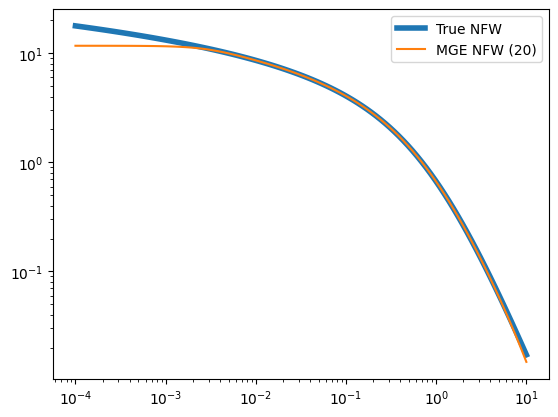

In [15]:
a, s = mge.decompose(**kwargs)
s_ = s.reshape(-1, 1)
r_ = jnp.logspace(-4, 1, 100, base=10)
ks = (a.reshape(-1, 1) * jnp.exp(-r_**2 / (2 * s_**2))).sum(axis=0)

k_ = NFW_fn(jnp.abs(r_), **kwargs)

plt.loglog(r_, k_, '-', lw=4, label='True NFW')
plt.loglog(r_, ks, '-', label=f'MGE NFW ({a.shape[0]})')
plt.legend();

In [16]:
extent = (x[0], x[-1], x[0], x[-1])


def plot_image(A, N):
    plt.imshow(A, norm=colors.CenteredNorm(), cmap='PuOr_r', extent=extent, origin='lower')
    plt.colorbar()
    plt.contour(
        A,
        np.quantile(A.flatten(), np.linspace(0, 1, N+2)[1:-1]),
        colors='k',
        extent=extent
    )
    plt.contour(
        A,
        [0],
        colors='C0',
        extent=extent
    )

## Jax version

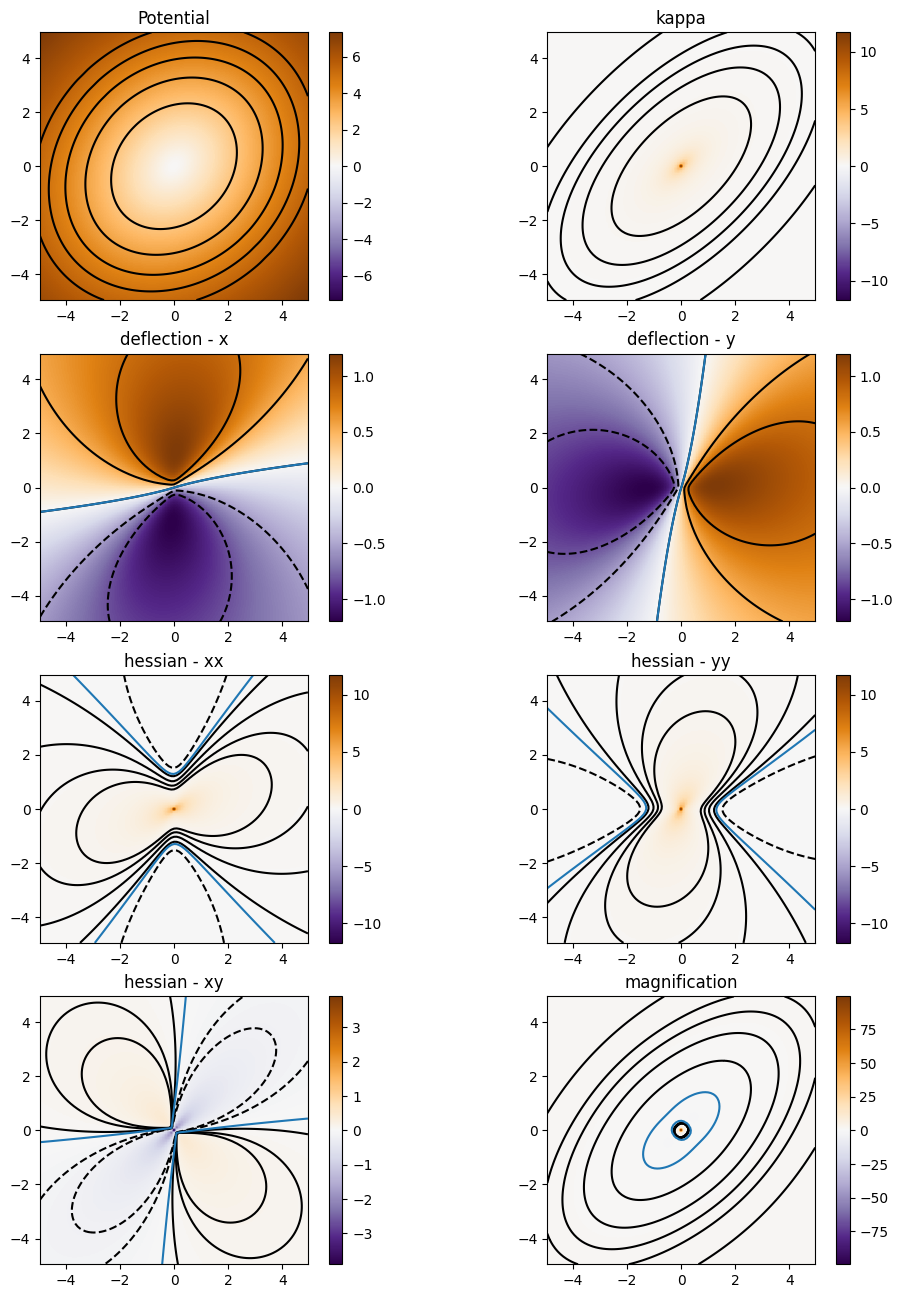

In [17]:
plt.figure(figsize=(12, 16))

plt.subplot(421)
plt.title('Potential')
plot_image(potential, 5)

plt.subplot(422)
plt.title('kappa')
plot_image(kappa, 5)

plt.subplot(423)
plt.title('deflection - x')
plot_image(dx, 5)
plt.subplot(424)
plt.title('deflection - y')
plot_image(dy, 5)

plt.subplot(425)
plt.title('hessian - xx')
plot_image(hxx, 5)
plt.subplot(426)
plt.title('hessian - yy')
plot_image(hyy, 5)
plt.subplot(427)
plt.title('hessian - xy')
plot_image(hxy, 5)

plt.subplot(428)
plt.title('magnification')
plot_image(inv_mag, 5);

## Lenstronomy version

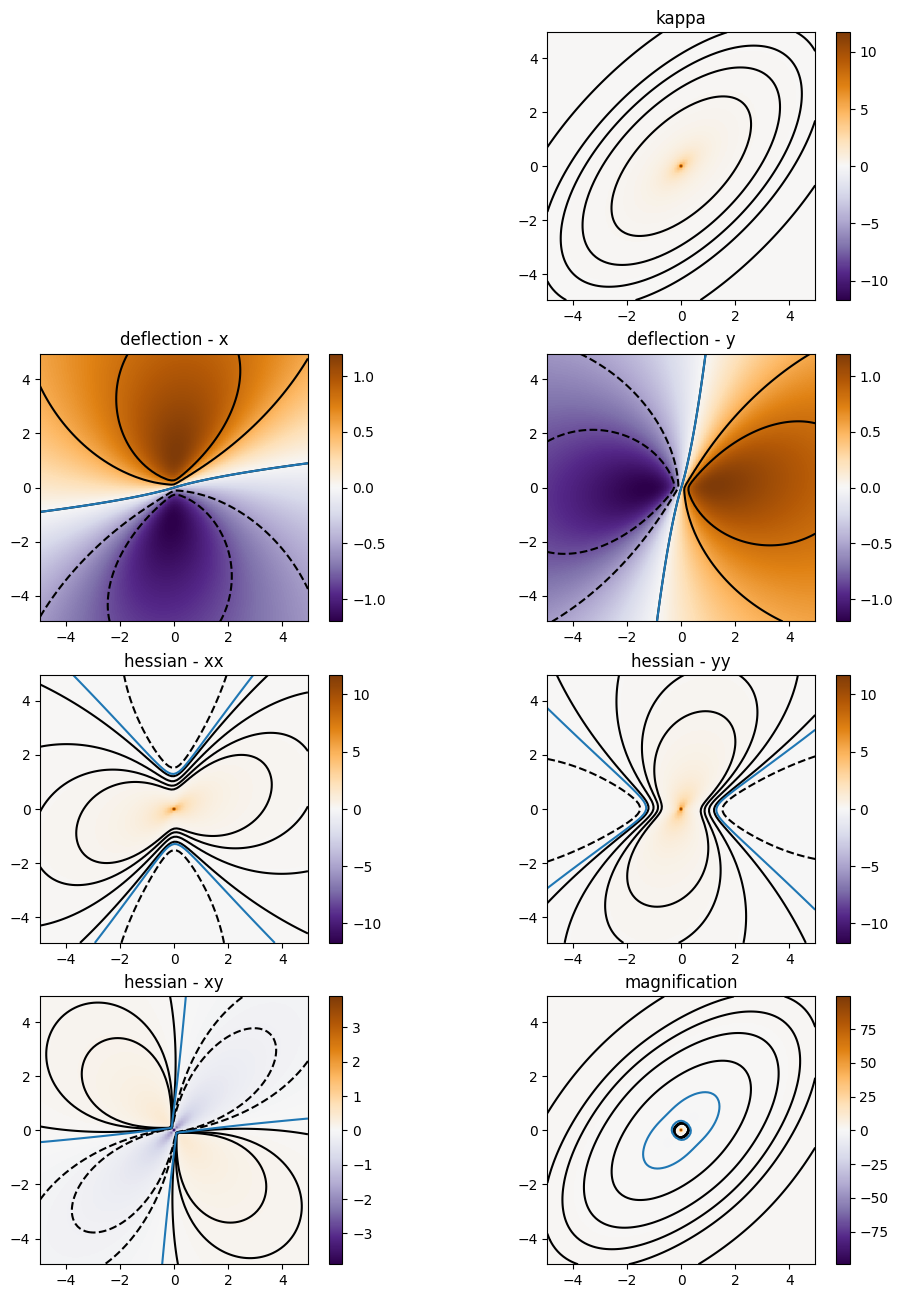

In [18]:
plt.figure(figsize=(12, 16))

# plt.subplot(421)
# plt.title('Potential')
# plot_image(potential_ref, 5)

plt.subplot(422)
plt.title('kappa')
plot_image(kappa_ref, 5)

plt.subplot(423)
plt.title('deflection - x')
plot_image(dx_ref, 5)
plt.subplot(424)
plt.title('deflection - y')
plot_image(dy_ref, 5)

plt.subplot(425)
plt.title('hessian - xx')
plot_image(hxx_ref, 5)
plt.subplot(426)
plt.title('hessian - yy')
plot_image(hyy_ref, 5)
plt.subplot(427)
plt.title('hessian - xy')
plot_image(hxy_ref, 5)

plt.subplot(428)
plt.title('magnification')
plot_image(inv_mag_ref, 5);

## Residuals

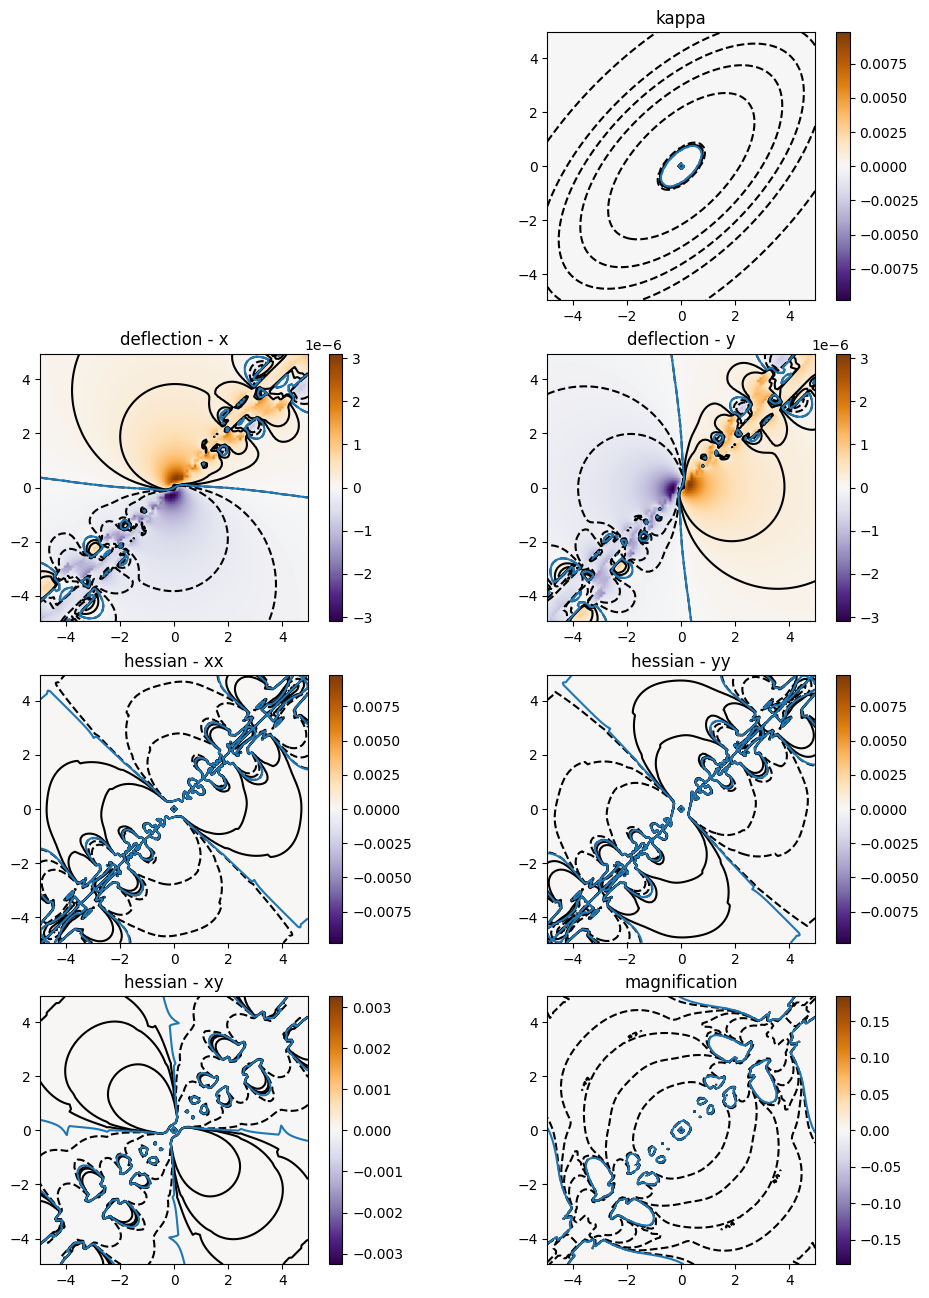

In [19]:
plt.figure(figsize=(12, 16))

# plt.subplot(421)
# plt.title('Potential')
# plot_image(potential_ref - potential, 5)

plt.subplot(422)
plt.title('kappa')
plot_image(kappa_ref -  kappa, 5)

plt.subplot(423)
plt.title('deflection - x')
plot_image(dx_ref - dx, 5)
plt.subplot(424)
plt.title('deflection - y')
plot_image(dy_ref - dy, 5)

plt.subplot(425)
plt.title('hessian - xx')
plot_image(hxx_ref - hxx, 5)
plt.subplot(426)
plt.title('hessian - yy')
plot_image(hyy_ref - hyy, 5)
plt.subplot(427)
plt.title('hessian - xy')
plot_image(hxy_ref - hxy, 5)

plt.subplot(428)
plt.title('magnification')
plot_image(inv_mag_ref - inv_mag, 5);

## Speed tests vs lenstronomy

In [20]:
%timeit jax.block_until_ready(jf(xx, yy, **kwargs))

279 ms ± 36.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit jax.block_until_ready(jd(xx, yy, **kwargs))

34 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit ref_nfw.derivatives(xx, yy, **kwargs2)

67.2 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit jax.block_until_ready(jh(xx, yy, **kwargs))

44.6 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%timeit ref_nfw.hessian(xx, yy, **kwargs2)

89.8 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
